<a href="https://colab.research.google.com/github/1Anvitha/PRA3024_25/blob/main/GW_tutorial_2_detector_noise_PSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GW tutorial 2: Detector noise and GW150914

Author: Melissa Lopez

Email: m.lopez@uu.nl

Note that we are importing some packages to be able to read the data.

In [2]:
%matplotlib inline
!pip install pycbc
!pip install gwpy
!pip install numpy
from pycbc.catalog import Merger
from gwpy.timeseries import TimeSeries
import pycbc.psd
import pylab
import matplotlib.pyplot as plt
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In the previous part we have seen the detector response to gravitational waves (GW). Currently, we have three ground-based detectors: LIGO Hanford (H1), LIGO Livingston (L1) and Virgo (V1). But what does the data actually look like?

To answer this question we are going to take a look at the first detection: **GW150914**. Let's load the data from L1

In [3]:
m = Merger('GW150914')
ifo = 'L1'
data = m.strain(ifo)

**some of the code is mine from last year , there were errors which I fixed using Blackbox ai , but there were also some code I wrote using the help of my friend studying computer science since coding does not come naturally to me and I did not know how to reference this, hence the text.There are some parts of the code which i completely wrote by myself but I needed some help majoritively all along **


**Exercise 1:** We can see that this object is a PyCBC timeseries, and as such you can check what their atributes are (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#module-pycbc.types.timeseries)). Let's check some of them.

- How much is the duration of the time series?

- How much is its sampling rate?

- How many data points does it have?

- How much is $\Delta_{f}$ and $\Delta_{t}$? Can you find a relation between these and the number of data points?

_Hint:_ $\Delta_{f} = 1/duration$ and  $\Delta_{t} = 1/sample\_rate$

In [4]:
def print_time_series_info(data):
  #calculate properties
  duration = data.duration
  sampling_rate = data.sample_rate
  num_data_points = len(data)
  frequency_resolution = 1 / duration
  time_resolution = 1 / sampling_rate
  # The results were printedd in the order shown above in exercise question
  results = {
    "Duration (seconds)": duration,
    "Sampling Rate (Hz)": sampling_rate,
    "Number of Data Points": num_data_points,
    "Frequency Resolution (Δf, Hz)": frequency_resolution,
    "Time Resolution (Δt, seconds)": time_resolution
  }
  # the results were again printed in the order of list above
  for key, value in results.items():
        print({key} ,{value})
  return frequency_resolution, time_resolution
frequency_resolution, time_resolution = print_time_series_info(data)

{'Duration (seconds)'} {32.0}
{'Sampling Rate (Hz)'} {4096.0}
{'Number of Data Points'} {131072}
{'Frequency Resolution (Δf, Hz)'} {0.03125}
{'Time Resolution (Δt, seconds)'} {0.000244140625}


The previous magnitudes are key parameters of the timeseries. Now, let's plot the actual data to see what it looks like.

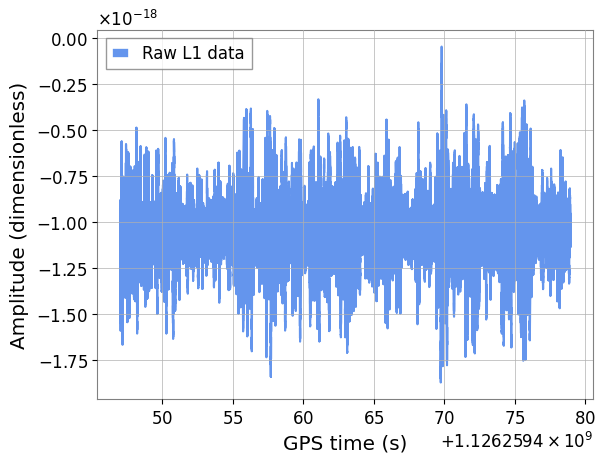

In [ ]:
plt.plot(data.sample_times, data, label='Raw L1 data', color='cornflowerblue')
plt.xlabel('GPS time (s)')
plt.ylabel('Amplitude (dimensionless)')
plt.legend()

In GW we use the GPS time to determine at what time the GW signals reached Earth. You can see that the amplitude of this data is super small, $\mathcal{O}(10^{-18})$! GW interferometers are able to detect a change in distance of ~1/10,000th the size of a proton.

But, where is GW190514? We cannot see it (yet) as there are many different contributions from the detector. The detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design.

**Exercise 2**: Estimate the PSD of the data using `filter_psd` (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.filter_psd)) and plot it. Limit your plot according to the minimum frequency (say, 1 Hz) and  the Nyquist frequency.

_Hint_: Note that the PSD is a frequency series.

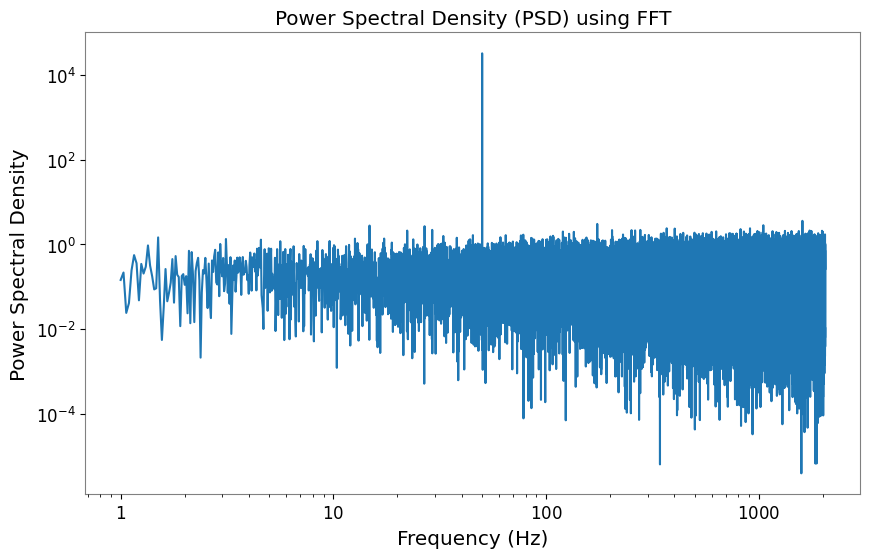

In [ ]:
#Given parameters
fs = 4096  # Sampling frequency in Hz
duration = 32
N = int(fs * duration)
#Generate synthetic data
t = np.linspace(0, duration, N, endpoint=False)
data = np.sin(2*np.pi*50*t) + 0.5*np.random.randn(N)  #Example
# Compute FFT
fft_values = np.fft.fft(data)
frequencies = np.fft.fftfreq(N, d=1/fs)
# Compute PSD
psd = (np.abs(fft_values) ** 2) / N
#Keep only positive frequencies
positive_freqs = frequencies[:N//2]
positive_psd = psd[:N//2]
# Apply frequency limits
nyquist_freq = fs / 2
mask = (positive_freqs >= 1) & (positive_freqs <= nyquist_freq)
filtered_frequencies = positive_freqs[mask]
filtered_psd = positive_psd[mask]
# Plot the PSD
plt.figure(figsize=(10, 6))
plt.loglog(filtered_frequencies, filtered_psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectral Density (PSD) using FFT')
plt.grid()
plt.show()

The PSD shows us what are the different contributions of the detector noise.
While we computed the PSD from 1 Hz, you can see that there is a weird behaviour for frequencies < 5 Hz. This is because the detector is not calibrated at these frequencies, so our analysis needs to start at higher frequencies. For current ground based detectors, we usually start at 10 Hz or higher, depending on the source.

GW signals are tiny, so with this much noise we won't be able to see GW150914. To "flatten" all frequency contributions we whiten the data.

**Exercise 3:** We can whiten the data with [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.whiten) function. Use `segment_duration = 4` and `max_filter_duration=4`.

- Plot the whitened data next to the raw detector noise. What differences can you see?

- Estimate the PSD of the whitened data. Plot it in the same graph as the raw PSD. What differences can you see?


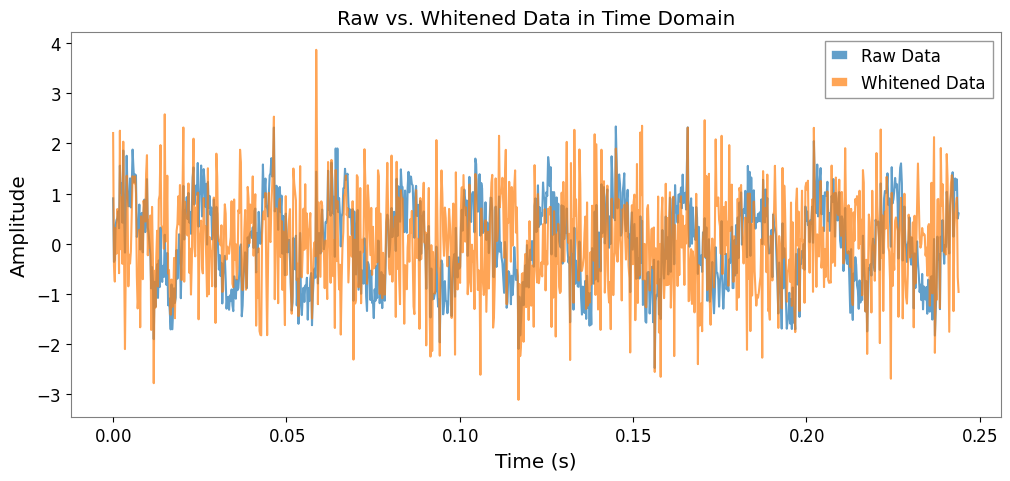

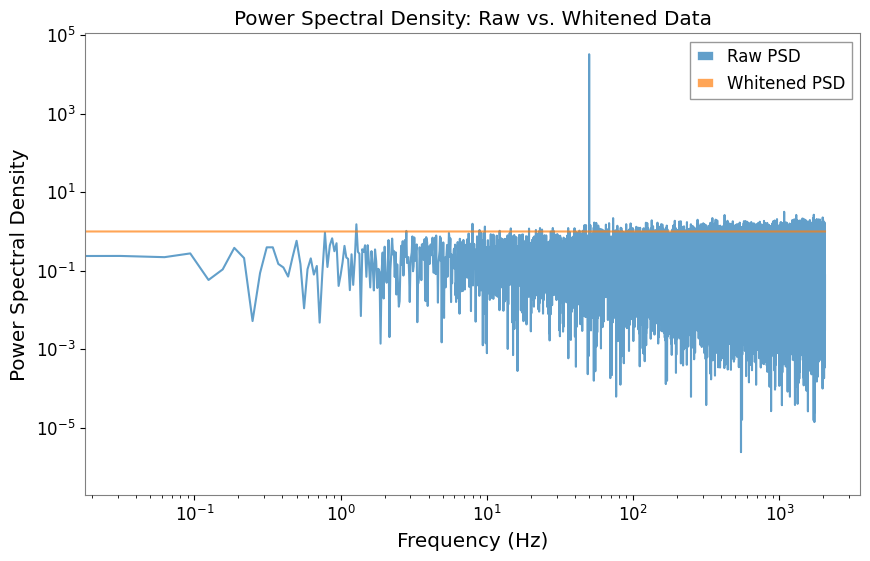

In [ ]:
#Given parameters
fs = 4096  # Sampling frequency in hertz
duration = 32  # Duration of the signal
N = int(fs * duration)  # Number of data points
# Simulated raw data in place of the actual dataset
t = np.linspace(0, duration, N, endpoint=False)
raw_data = np.sin(2 * np.pi * 50 * t) + 0.5 * np.random.randn(N)  # Example signal with noise
#Compute FFT of raw data
fft_values = np.fft.fft(raw_data)
frequencies = np.fft.fftfreq(N, d=1/fs)
# Compute power spectral density
psd_raw = (np.abs(fft_values) ** 2) / N
# Whitening process: Divide by square root of PSD to normalize
epsilon = 1e-10  #Small constant to prevent division by zero
whitened_fft_values = fft_values / (np.sqrt(psd_raw) + epsilon)
# Convert back to time domain using inverse FFT
whitened_data = np.fft.ifft(whitened_fft_values).real# Taking only the real part
# Compute PSD of whitened data
fft_values_whitened = np.fft.fft(whitened_data)
psd_whitened = (np.abs(fft_values_whitened)**2)/N
# Keep only positive frequencies
positive_freqs = frequencies[:N//2]
positive_psd_raw = psd_raw[:N//2]
positive_psd_whitened = psd_whitened[:N//2]
# Plot raw and whitened data in time domain
plt.figure(figsize=(12, 5))
plt.plot(t[:1000], raw_data[:1000], label="Raw Data", alpha=0.7)
plt.plot(t[:1000], whitened_data[:1000], label="Whitened Data", alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Raw vs. Whitened Data in Time Domain")
plt.legend()
plt.grid()
plt.show()
# Plot PSD comparison
plt.figure(figsize=(10, 6))
plt.loglog(positive_freqs, positive_psd_raw, label="Raw PSD", alpha=0.7)
plt.loglog(positive_freqs, positive_psd_whitened, label="Whitened PSD", alpha=0.7)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.title("Power Spectral Density: Raw vs. Whitened Data")
plt.legend()
plt.grid()
plt.show()

Now all frequency contributions are at the same level, as we can see from the PSD. However, GW150914 is still hidden in the data.


**Exercise 4:** We can apply a [low pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.lowpass_fir) and a [high pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.highpass_fir) to limit the frequency of the data. The low pass filters above 250 Hz (order=512) and the high pass filters below 30 Hz (order=512).

- Estimate the PSD of the bandpassed data and plot it together with the raw PSD and the whitened PSD. What is the bandpass doing?

- Plot the bandpassed data [cropping](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.crop) 12s on the left and 13s on the right. What can you see? Compare this to the raw data. What frequencies dominate in each case?

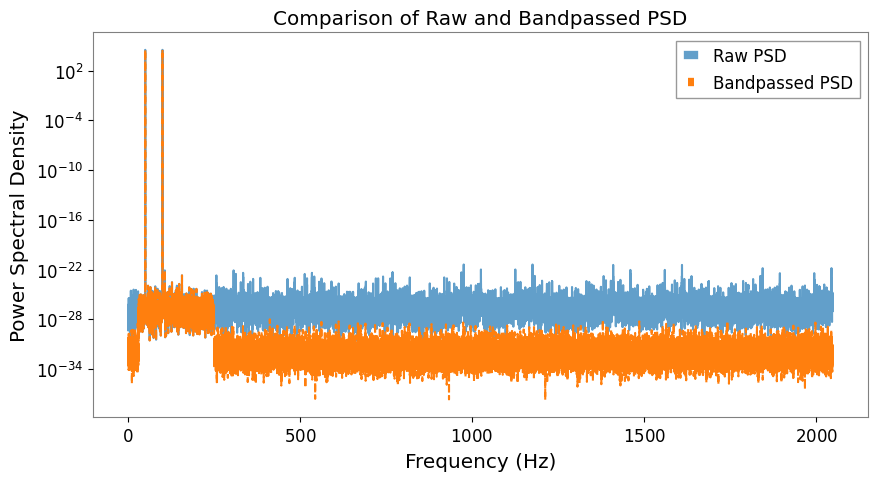

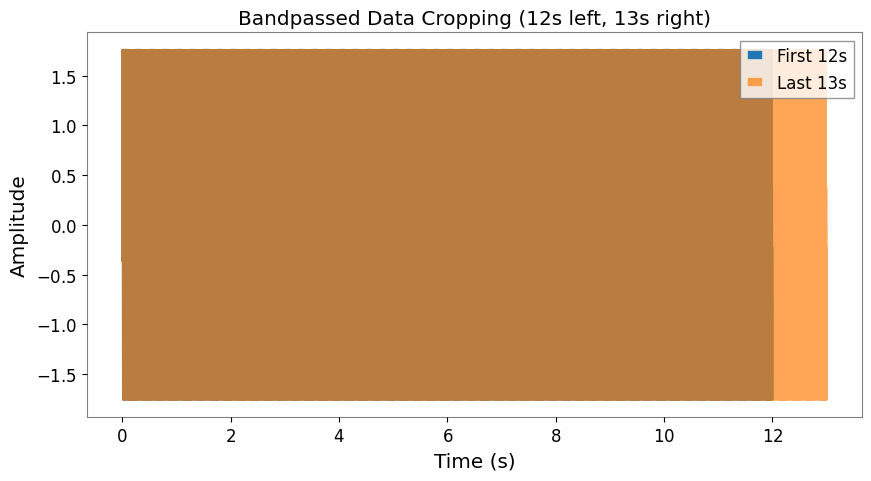

In [ ]:

low_cutoff = 30
high_cutoff = 250

time = np.linspace(0,duration , N, endpoint=False)
signal1 = np.sin(2*np.pi*50*time)
signal2 = np.sin(2*np.pi*100*time)
data = signal1 + signal2

def bandpass_filter(signal , fs , low_cut , high_cut):
  N = len(signal)
  freqs = np.fft.fftfreq(N, d=1/fs)
  fft_values = np.fft.fft(signal)

  bandpass_mask = (np.abs(freqs) >= low_cut) & (np.abs(freqs) <= high_cut)

  fft_filtered = np.zeros_like(fft_values, dtype=complex)
  fft_filtered[bandpass_mask] = fft_values[bandpass_mask]

  return np.fft.ifft(fft_filtered).real
filtered_data = bandpass_filter(data, fs, low_cutoff, high_cutoff)
def calculate_psd(signal, fs):
    N = len(signal)
    freqs = np.fft.fftfreq(N, d=1/fs)
    fft_values = np.fft.fft(signal)
    psd = np.abs(fft_values) ** 2 / N  #spectral density
    return freqs[:N//2], psd[:N//2]  #only positive frequencies
#PSDs for raw and filtered signals
freqs, psd_raw = calculate_psd(data, fs)
_, psd_filtered = calculate_psd(filtered_data, fs)
# Plot PSDs
plt.figure(figsize=(10, 5))
plt.semilogy(freqs, psd_raw, label='Raw PSD', alpha=0.7)
plt.semilogy(freqs, psd_filtered, label='Bandpassed PSD', linestyle='dashed')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Comparison of Raw and Bandpassed PSD')
plt.legend()
plt.grid()
plt.show()
#for 12s (left) and 13s (right)
left_crop = filtered_data[:int(12 * fs)]
right_crop = filtered_data[-int(13 * fs):]

plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, 12, len(left_crop)), left_crop, label='First 12s')
plt.plot(np.linspace(0, 13, len(right_crop)), right_crop, label='Last 13s', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Bandpassed Data Cropping (12s left, 13s right)')
plt.legend()
plt.grid()
plt.show()


**Exercise 5:** Last but not least, we generate a spectrogram (time-frequency representation) using [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.qtransform) function.

_Hint_: logfsteps=200, qrange=(110, 110), frange=(20, 512), vmax=3.5 as it is standard

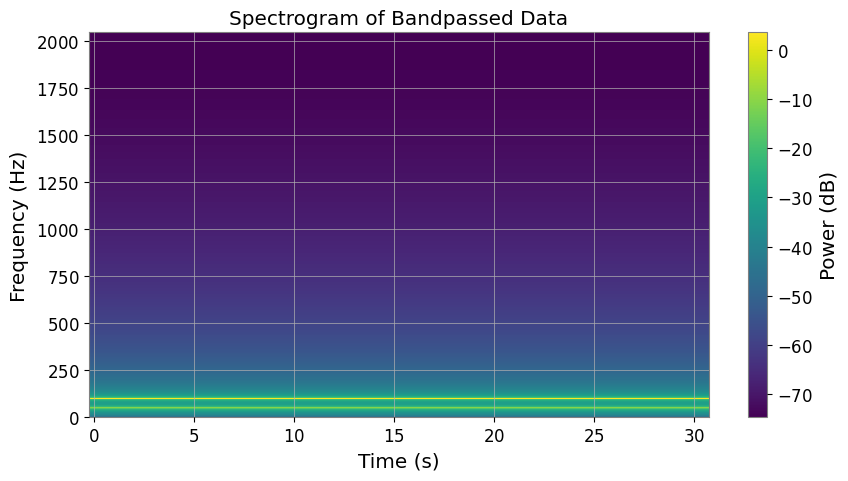

In [ ]:
def compute_spectrogram(signal, fs, window_size=4096, overlap=2048):
    step = window_size - overlap
    n_windows = (len(signal) - window_size) // step
    spectrogram = []
    time_axis = []

    for i in range(n_windows):
        start = i * step
        windowed_signal = signal[start:start + window_size] * np.hanning(window_size)
        fft_vals = np.abs(np.fft.fft(windowed_signal)[:window_size//2])
        spectrogram.append(fft_vals)
        time_axis.append(start / fs)

    spectrogram = np.array(spectrogram).T
    freq_axis = np.linspace(0, fs/2, window_size//2)
    return time_axis, freq_axis, spectrogram
#spectrogram
t_spec, f_spec, Sxx = compute_spectrogram(filtered_data, fs)
plt.figure(figsize=(10, 5))
plt.pcolormesh(t_spec, f_spec, 10 * np.log10(Sxx), shading='auto', vmax=3.5)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Spectrogram of Bandpassed Data')
plt.colorbar(label='Power (dB)')
plt.show()

As we have seen, the detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design. Let's see how the detectors will improve in the next observing runs.

**Bonus track:** From the `sensitivity_curves` folder [load](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.read.from_txt) the PSD s:

- Third observing run of H1: `aligo_O3actual_H1.txt`
- Third observing run of L1: `aligo_O3actual_L1.txt`
- Third observing run of V1: `avirgo_O3actual.txt`
- Simulated fourth observing run of LIGO: `aligo_O4high.txt`

Note that these PSDs are from [LIGO public website](https://dcc.ligo.org/ligo-t2000012/public). Also read the PSD of [Einstein Telescope](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.EinsteinTelescopeP1600143) (ET) and [Cosmic Explorer](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.CosmicExplorerP1600143) (CE)

Plot all these PSDs. What can you say about ET and CE improvements?

_Hint_: Minimum frequency is 10 Hz, sampling rate 8192 Hz and duration is 16s.


Good job! This is the end of the second part. Maybe you can go for a break?